In [20]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gcsfs
import os
import matplotlib.pyplot as plt

#from keras.models import Sequential
#from keras.layers import Dense
import tensorflow as tf


from sklearn.model_selection import train_test_split

In [21]:
#%env PROJECT_ID=

In [22]:
# fs = gcsfs.GCSFileSystem(project=os.environ['PROJECT_ID'])
# bucket_name = 'physionet_2009'
# fs.ls(bucket_name)

In [23]:
CSV_COLUMNS = ['wave', 'start_window', 'end_window', 'avg_sys', 'avg_dias', 'avg_map',
       'current_hypotensive', 'hypotensive_in_15']
DEFAULTS = [[''],[0.0],[0.0],[0.0],[0.0],[0.0],
            [0.0],[0.0]]

LABEL_COLUMN = 'hypotensive_in_15'

In [24]:
# #training = get_training_labels()
# training_data = pd.read_csv(fs.open(f'{bucket_name}/processed/processed_all.csv'))

# training_data.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)
# training_data.columns

In [25]:
# Make dataset

In [26]:
def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.

    Args:
        row_data: Dictionary of CSV column names and tensor values.
    Returns:
        Dictionary of feature tensors and label tensor.
    """
    label = row_data.pop(LABEL_COLUMN)

    return row_data, label  # features, label


def load_dataset(pattern,csv_columns,defaults,label_column, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    """Loads dataset using the tf.data API from CSV files.

    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: tf.estimator.ModeKeys to determine if training or evaluating.
    Returns:
        `Dataset` object.
    """
    # Make a CSV dataset
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=csv_columns,
        column_defaults=defaults)
    print(type(dataset))

    # Map dataset to features and label
    dataset = dataset.map(map_func=features_and_labels)  # features, label
    
    # Shuffle and repeat for training
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000)# .repeat()

    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

AttributeError: module 'tensorflow' has no attribute 'estimator'

In [8]:
train_df = load_dataset(pattern = 'data/training_data_cleaned.csv',
                        csv_columns = CSV_COLUMNS,
                        defaults = DEFAULTS,
                        label_column = LABEL_COLUMN,
                        mode=tf.estimator.ModeKeys.TRAIN)

test_df = load_dataset(pattern = 'data/test_data_cleaned.csv',
                        csv_columns = CSV_COLUMNS,
                        defaults = DEFAULTS,
                        label_column = LABEL_COLUMN,
                        mode=tf.estimator.ModeKeys.EVAL)

NameError: name 'load_dataset' is not defined

In [70]:
for feature_batch in train_df.take(1):
    # print(feature_batch)
    for item in feature_batch[0]:
        print(item)

tf.Tensor(0.0, shape=(), dtype=float32)


In [57]:
# Create input layers

In [58]:
def create_input_layers():
    """Creates dictionary of input layers for each feature.

    Returns:
        Dictionary of `tf.Keras.layers.Input` layers for each feature.
    """
    inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="float32")
        for colname in ["avg_sys", "avg_dias"]}
    '''
    inputs.update({
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="string")
        for colname in ["is_male", "plurality"]})
    '''

    return inputs

In [59]:
# Create feature columns

In [60]:
def categorical_fc(name, values):
    """Helper function to wrap categorical feature by indicator column.

    Args:
        name: str, name of feature.
        values: list, list of strings of categorical values.
    Returns:
        Indicator column of categorical feature.
    """
    cat_column = tf.feature_column.categorical_column_with_vocabulary_list(
            key=name, vocabulary_list=values)

    return tf.feature_column.indicator_column(categorical_column=cat_column)


def create_feature_columns():
    """Creates dictionary of feature columns from inputs.

    Returns:
        Dictionary of feature columns.
    """
    feature_columns = {
        colname : tf.feature_column.numeric_column(key=colname)
           for colname in ["avg_sys", "avg_dias"]
    }
    '''
    feature_columns["is_male"] = categorical_fc(
        "is_male", ["True", "False", "Unknown"])
    feature_columns["plurality"] = categorical_fc(
        "plurality", ["Single(1)", "Twins(2)", "Triplets(3)",
                      "Quadruplets(4)", "Quintuplets(5)", "Multiple(2+)"])
    '''
    return feature_columns

In [61]:
# Create hidden and output layer

In [62]:
def get_model_outputs(inputs):
    """Creates model architecture and returns outputs.

    Args:
        inputs: Dense tensor used as inputs to model.
    Returns:
        Dense tensor output from the model.
    """
    # Create two hidden layers of [64, 32] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(64, activation="relu", name="h1")(inputs)
    h2 = tf.keras.layers.Dense(32, activation="relu", name="h2")(h1)

    # Final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(
        units=1, activation="sigmoid", name="weight")(h2)

    return output

In [63]:
# Build model

In [64]:
def build_dnn_model():
    """Builds simple DNN using Keras Functional API.

    Returns:
        `tf.keras.models.Model` object.
    """
    # Create input layer
    inputs = create_input_layers()

    # Create feature columns
    feature_columns = create_feature_columns()

    # The constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(
        feature_columns=feature_columns.values())(inputs)

    # Get output of model given inputs
    output = get_model_outputs(dnn_inputs)

    # Build model and compile it all together
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['AUC','Precision','Recall'])

    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
avg_dias (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
avg_sys (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
dense_features_1 (DenseFeatures (None, 2)            0           avg_dias[0][0]                   
                                                                 avg_sys[0][0]                    
__________________________________________________________________________________________________
h1 (Dense)                      (None, 64)       

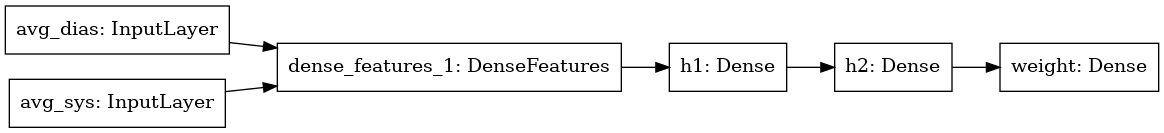

In [65]:
tf.keras.utils.plot_model(
    model=model, show_shapes=False, rankdir="LR")

In [66]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 1000 # 256871  # training dataset repeats, it'll wrap around
NUM_EVALS = 2  # how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 10

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)
steps_per_epoch

15

In [68]:
history = model.fit(
    test_df,
    validation_data=test_df,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch #,
    #callbacks=[tensorboard_callback]
)

Epoch 1/2
 5/15 [=========>....................] - ETA: 0s - loss: 6.4177e-04 - auc: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
history

In [ ]:
# Plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

#for idx, key in enumerate(["loss", "rmse"]):
#    ax = fig.add_subplot(nrows, ncols, idx+1)
#    plt.plot(history.history[key])
#    plt.plot(history.history["val_{}".format(key)])
#    plt.title("model {}".format(key))
#    plt.ylabel(key)
#    plt.xlabel("epoch")
#    plt.legend(["train", "validation"], loc="upper left");